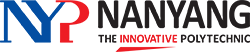

# IT2311 Assignment - Task 2: Sentiment Classification

You are required to build a sentiment classification model predict the sentiment of the review text. Businesses will be able to use this model to predict the sentiment of a new review.

Complete the following sub-tasks:
1. **Load Data**: Load the clean dataset
2. **Data Preparation**: Prepares the text representation for this task
3. **Modelling**: Perform sentiment classification using different text representation and modelling techniques
4. **Evaluation**: Evaluates results from the algorithms and select the best model

For each sub-task, perform the necessary steps and **explain the rationale taken for each step in this Jupyter notebook**. 

**Done by: Navodita 230238Q\**

## Import libraries and download the packages

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from bs4 import BeautifulSoup
import html
import re
import string
from wordcloud import WordCloud
from scipy.sparse import vstack
import gensim
from gensim import corpora
from gensim.models import Word2Vec
from gensim.models import TfidfModel

In [3]:
import nltk
nltk.download("all")
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\admin\AppData\Roaming\nltk_data...
[

## Load Data

In [4]:
df = pd.read_json('Digital_Music.jsonl.gz', lines=True, compression='gzip')

## Data Preparation
Perform the necessary steps and explain the rationale taken here.

##### Keeping only columns that are needed for the sentiment classification

In [5]:
df = df[['rating', 'text']]

##### Check for rows with missing values

In [6]:
print(df.isnull().sum())

rating    0
text      0
dtype: int64


There are no rows with missing values, but there is a likelihood of having undefined values in the dataframe because .isnull() checks for only rows with missing values and not undefined values. .isna() is used to check for rows with undefined values later.

##### Check for rows with undefined values

In [7]:
# Convert empty strings and whitespace-only strings to NaN if there are any
df['text'] = df['text'].replace(r'^\s*$', np.nan, regex=True)

In [8]:
# Detect NaN values
print("Rows with NaN values:")
nan_rows = df[df['text'].isna()]
print("The number of rows with undefined values:", nan_rows.shape[0])

Rows with NaN values:
The number of rows with missing values: 50


Since the number of rows with undefined values is a very small propotion in the entire dataset, there will not be any significant data loss when these rows with Nan values are removed.

In [9]:
# Remove rows with NaN values
df = df.dropna(subset=['text']).reset_index(drop=True)

In [10]:
print("\nDataFrame after removing rows with NaN values:")
df


DataFrame after removing rows with NaN values:


,rating,text
0,5,If i had a dollar for how many times I have pl...
1,5,awesome sound - cant wait to see them in perso...
2,5,This is a great cd. Good music and plays well....
3,1,"These are not real German singers, they have a..."
4,3,I first heard this playing in a Nagoya shop an...
...,...,...
130379,5,BTS order exceeded my expectations as always
130380,5,"received the album in good condition, and ther..."
130381,5,Me encantó este Cd
130382,1,A pathetic attempt at something. I can't ident...


##### Check for duplicate values

In [11]:
print(df.duplicated().sum())

11289


Since there are duplicate values present in the dataframe, the duplicate rows (keeping the first occurence) needs to be removed. This will not cause any data loss because, the first occurrence of duplicate rows is still kept in the dataframe.

##### Removing the duplicate values except the first occurrence

In [12]:
# number of rows before removing duplicate values
df.shape[0]

130384

In [13]:
# removing the duplicate values (keeping the first occurrence)
df = df.drop_duplicates(keep='first').reset_index(drop=True)
df

,rating,text
0,5,If i had a dollar for how many times I have pl...
1,5,awesome sound - cant wait to see them in perso...
2,5,This is a great cd. Good music and plays well....
3,1,"These are not real German singers, they have a..."
4,3,I first heard this playing in a Nagoya shop an...
...,...,...
119090,5,BTS order exceeded my expectations as always
119091,5,"received the album in good condition, and ther..."
119092,5,Me encantó este Cd
119093,1,A pathetic attempt at something. I can't ident...


In [14]:
# number of rows after the removal of duplicate values
df.shape[0]

119095

Since the number of rows had decreased after the removal of duplicate values, it has been verified that the duplicate values (keeping the first occurrence) has been removed.

##### Create a sentiment column

In [15]:
# check the range of values in rating column
# maximum rating value
print("Maximum rating value:", df['rating'].max())

# minimum rating value
print("Minimum rating value:", df['rating'].min())

Maximum rating value: 5
Minimum rating value: 1


Since the ratings is from 1 to 5, the sentiment column will contain values such as "Positive", "Negative" and "Neutral". Ratings 1 and 2 represent "Negative" sentiment, rating 3 represent "Neutral" sentiment and ratings 4 and 5 represent "Positive" sentiment.

In [16]:
# convert the rating to sentiment
def classify_sentiment(rating):
    if rating in [1, 2]:   #Rating 1 or 2 is negative sentiment
        return 'Negative'
    elif rating == 3:     #Rating 3 is neutral sentiment
        return 'Neutral'
    else:                # Rating 4 or 5 is positive sentiment
        return 'Positive'

df['sentiment'] = df['rating'].apply(classify_sentiment)

In [17]:
# re-arranging the columns
df = df[[df.columns[0], 'sentiment'] + df.columns.tolist()[1:-1]]

# remove the rating column
df = df.drop('rating', axis=1)

df.head()

,sentiment,text
0,Positive,If i had a dollar for how many times I have pl...
1,Positive,awesome sound - cant wait to see them in perso...
2,Positive,This is a great cd. Good music and plays well....
3,Negative,"These are not real German singers, they have a..."
4,Neutral,I first heard this playing in a Nagoya shop an...


Ratings column is removed since it is no longer going to be used. Sentiment column will be used as target variable for the sentiment classification

##### Check the distribution of sentiments
Distribution of sentiment is analysed to see if the number of reviews with the 3 different sentiments is relatively balanced.

C:\Users\admin\AppData\Local\Temp\ipykernel_16200\4027112092.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


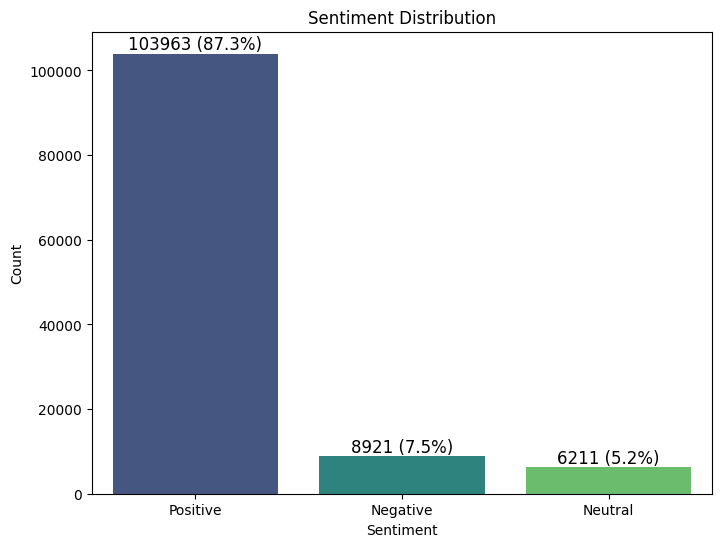

In [18]:
# Count the sentiment values
sentiment_counts = df['sentiment'].value_counts()

# Calculate the total number of sentiments
total_sentiments = len(df)

# Create a bar plot
plt.figure(figsize=(8,6))
ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')

# Add labels on top of each bar with both count and percentage
for i, v in enumerate(sentiment_counts.values):
    percentage = (v / total_sentiments) * 100  # Calculate percentage
    label = f"{v} ({percentage:.1f}%)"  # Format the label
    ax.text(i, v + 5, label, ha='center', va='bottom', fontsize=12)  # Position the label

# Set labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')

# Show the plot
plt.show()

The sentiment distribution indicates a significant imbalance in the dataset. Without addressing this imbalance, the model is likely to overfit, becoming overly accustomed to reviews with positive sentiment. The number of negative and neutral sentiment reviews is considerably lower compared to positive sentiment reviews, providing insufficient data for the model to accurately predict negative or neutral sentiments. Therefore, balancing the dataset is necessary. However, before applying any balancing techniques, the dataset should first be split into training and testing sets.

##### split the data to testing and training data

In [19]:
# Split data into training and testing sets (stratified to maintain the sentiment distribution)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['sentiment'], random_state=42)

# Reset the index for both training and testing data
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

Stratified random sampling was used to maintain the original sentiment distribution in the dataset, ensuring that the testing data reflects real-world scenarios where most reviews are positive.  

*Stratified random sampling divides data into distinct groups (strata) and samples proportionally from each, preserving the overall class distribution.*

##### Verify that the distribution of sentiments in the training and testing data remains the same


In [20]:
# Function to plot sentiment distribution with counts and percentages
def plot_sentiment_distribution(data, title):
    sentiment_counts = data['sentiment'].value_counts()
    total_sentiments = len(data)
    
    plt.figure(figsize=(8,6))
    ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
    
    for i, v in enumerate(sentiment_counts.values):
        percentage = (v / total_sentiments) * 100  # Calculate percentage
        label = f"{v} ({percentage:.1f}%)"  # Format the label
        ax.text(i, v + 5, label, ha='center', va='bottom', fontsize=12)  # Position the label
    
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.title(title)
    plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_16200\2623118942.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


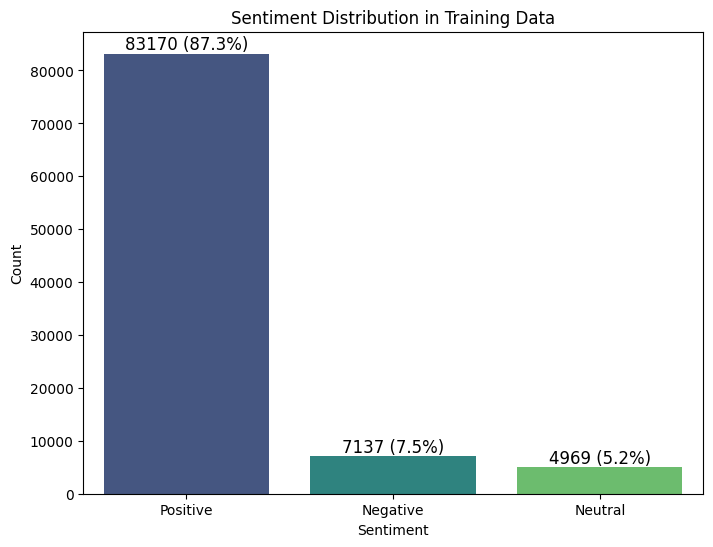

In [21]:
# Plot for training data
plot_sentiment_distribution(train_df, 'Sentiment Distribution in Training Data')

C:\Users\admin\AppData\Local\Temp\ipykernel_16200\2623118942.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


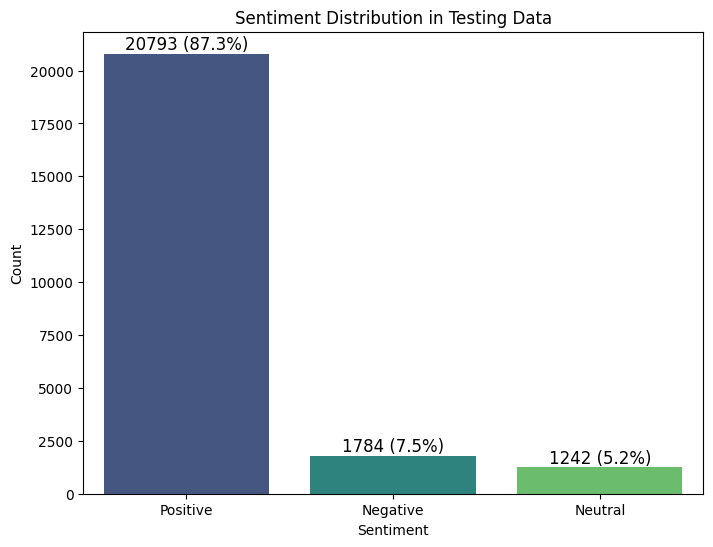

In [22]:
# Plot for testing data
plot_sentiment_distribution(test_df, 'Sentiment Distribution in Testing Data')

Since the distribution of testing and training dataset remains the same, we can now proceed to the next step.

##### Check the distribution of length of words in the positive sentiment
Analyzing the distribution of word lengths is essential, as reviews can vary significantly in length, from very short to extensive. Preserving this variance is important when performing stratified undersampling, because it ensures the model is exposed to a diverse range of reviews, improving its ability to accurately predict sentiment for both short and long texts.

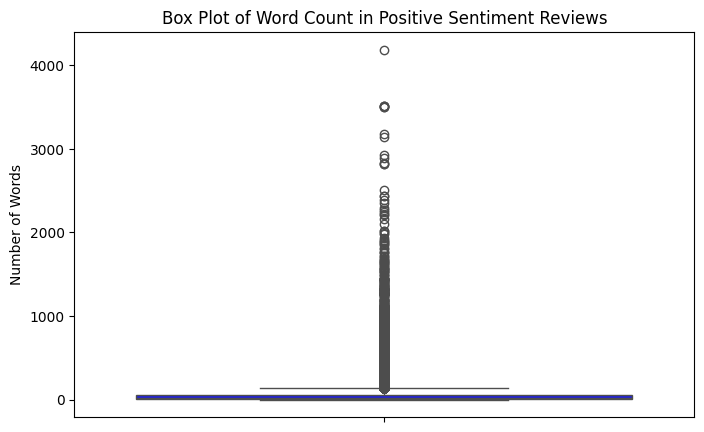

count    83170.000000
mean        62.330961
std        126.918428
min          1.000000
25%         10.000000
50%         25.000000
75%         61.000000
max       4187.000000
Name: word_count, dtype: float64


In [23]:
# Filter a copy of reviews with positive sentiment from df
positive_reviews = train_df[train_df['sentiment'] == 'Positive'].copy()

# Calculate the word count for each review
positive_reviews['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))

# 3. Create a box plot for the word count distribution in positive sentiment reviews
plt.figure(figsize=(8, 5))
sns.boxplot(y=positive_reviews['word_count'], color='blue')

# Adding labels and title
plt.ylabel('Number of Words')
plt.title('Box Plot of Word Count in Positive Sentiment Reviews')

# Show the plot
plt.show()

# Optional: Show summary statistics for the word count in positive sentiment reviews
print(positive_reviews['word_count'].describe())

##### Stratified undersampling for the positive sentiment
The distribution of word lengths is preserved by creating strata based on key percentiles, including the minimum, maximum, 25th, 50th, and 75th percentiles. Samples are then removed within each stratum to ensure the original distribution of word lengths is maintained, allowing the model to handle both short and long reviews effectively.

In [24]:
# Count the number of negative + neutral sentiments
neutral_count = train_df[train_df['sentiment'].isin(['Neutral'])].shape[0]

# Compute the new target number for positive sentiment (60% of total)
target_positive_count = int(neutral_count / 40 * 60)

print(neutral_count)
print(target_positive_count)

4969
7453


In [25]:
# Filtering out a copy of all the rows with positive sentiment
positive_reviews = train_df[train_df['sentiment'] == 'Positive'].copy()

In [26]:
# Calculate the word_count
positive_reviews['word_count'] = positive_reviews['text'].apply(lambda x: len(str(x).split()))

In [27]:
q1, q2, q3, min_val, max_val = (
    positive_reviews["word_count"].quantile(0.25),
    positive_reviews["word_count"].median(),
    positive_reviews["word_count"].quantile(0.75),
    positive_reviews["word_count"].min(),
    positive_reviews["word_count"].max(),
)

In [28]:
# Perform stratified undersampling
positive_undersampled = positive_reviews.groupby(
    pd.cut(positive_reviews["word_count"], bins=[min_val, q1, q2, q3, max_val])
).apply(lambda x: x.sample(frac=target_positive_count / len(positive_reviews), random_state=42))

positive_undersampled = positive_undersampled.reset_index(drop=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_16200\4092482822.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  positive_undersampled = positive_reviews.groupby(


In [29]:
# creating the new train_df with undersampled positive reviews
train_df = pd.concat([
    train_df[~train_df['sentiment'].isin(['Positive'])],  # Keep all neutral/negative reviews
    positive_undersampled  # Add the undersampled positive reviews
]).reset_index(drop=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_16200\2623118942.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


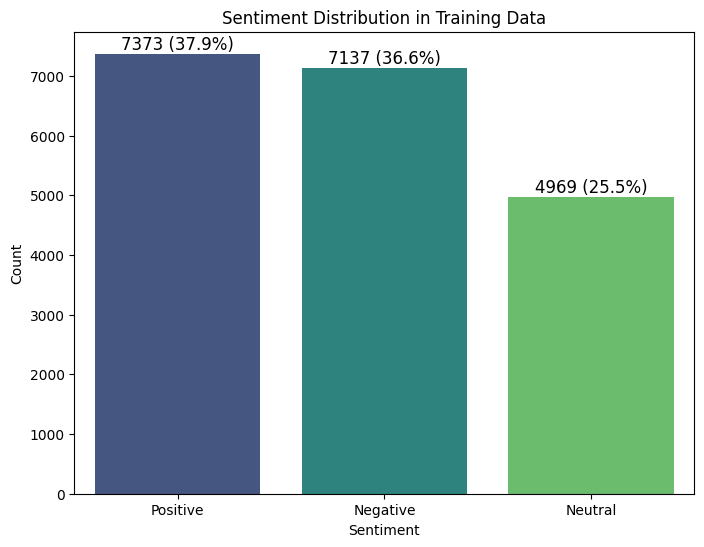

In [30]:
# Check the distribution of training data after stratified undersampling of reviews with positive sentiment
plot_sentiment_distribution(train_df, 'Sentiment Distribution in Training Data')

In [31]:
# Verifying if the distribution of reviews of various lengths is preserved (original distribution of positive reviews).
train_df['word_count'].describe()

count    7373.000000
mean       63.258104
std       121.854433
min         2.000000
25%        10.000000
50%        25.000000
75%        62.000000
max      3184.000000
Name: word_count, dtype: float64

In [32]:
# drop the word_count column as it is no longer going to be used
train_df = train_df.drop('word_count', axis=1)

##### Create a frequency distribution of all words
A frequency distribution of all the words is crucial for analyzing the text of the reviews. It provides valuable insights, such as identifying the top 10 most common words in the dataset and assessing whether these words are meaningful. Additionally, it helps highlight other terms that may need to be removed, beyond just punctuation and stopwords, to improve the quality and performance of the text for modeling.

In [33]:
train_df

,sentiment,text
0,Negative,no good
1,Neutral,Tracklist<br />1. Courtney Barnett - &#34;Avan...
2,Negative,Ad did not have a kist of songs. I bought blin...
3,Neutral,Cute fairy but arrived with her wings broken o...
4,Neutral,The music itself is great. The problem was the...
...,...,...
19474,Positive,"I came across this on Eb*y, and negotiated ali..."
19475,Positive,Jerome Moross is one of those composers who se...
19476,Positive,"If your looking at KTel vinyl, your not in it ..."
19477,Positive,"This is an excellent 88-track collection, whic..."


In [34]:
# adding all the words in the reviews into a list
all_words = [word.lower() for sent in train_df.text for word in word_tokenize(sent)]

#print first 10 words
all_words[:10]

['no', 'good', 'tracklist', '<', 'br', '/', '>', '1', '.', 'courtney']

In [35]:
freq_dist = FreqDist(all_words)
print(freq_dist)

#print the 10 most frequently occuring words
print(freq_dist.most_common(10))

<FreqDist with 60179 samples and 1710157 outcomes>
[('the', 73537), ('.', 67206), (',', 59790), ('and', 34842), ('of', 32614), ('a', 31686), ('i', 29887), ('to', 26710), ('/', 26207), ('br', 25781)]


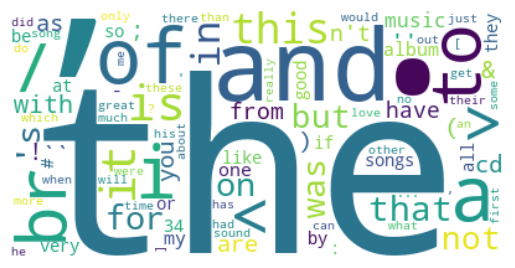

Figure 1


In [36]:
# creating a wordcloud from the frequency distribution for the top 100 most frequent words
wcloud = WordCloud(max_words=100, background_color="white").generate_from_frequencies(freq_dist)

#plot the word cloud
plt.imshow(wcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
print("Figure 1")

The word cloud analysis reveals that the top 100 words primarily consist of common stopwords like "the," "of," and "and," indicating the need to remove such stopwords from the dataset. It also highlights negation words like "not," which, though typically considered stopwords, play an important role in altering the meaning of sentences (e.g., "not good"). Therefore, "not" should be preserved and appended to the following token. Additionally, the word cloud shows the presence of HTML tags such as "br" and punctuation marks, both of which should be removed to clean the dataset.

#### Text preprocessing

In [37]:
# removing some common negation words from stopwords list
stopwords_english = set(stopwords.words('english'))
stopwords_english.remove('not')
stopwords_english.remove('no')
stopwords_english.remove('nor')

lemmatizer = WordNetLemmatizer()

#function for preprocessing text
def cleaning_text(html_text):
    """Cleans text: removes HTML, entities, stopwords, applies negation handling, and lemmatizes."""
    if html_text is None:
        return ""
    if not isinstance(html_text, str):
        return ""

    # Remove HTML tags
    soup = BeautifulSoup(html_text, "html.parser")
    text = soup.get_text(separator=' ')
    text = html.unescape(text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenization
    tokens = word_tokenize(text)
    all_words_clean = []
    negation_active = False  # Track if a negation is modifying the next words

    for word in tokens:
        word_lower = word.lower()

        # If the word is a negation, activate negation flag (but don't keep "not" as a separate token)
        if word_lower in {'not', 'no', 'nor'}:
            negation_active = True
            continue  # Skip adding the negation word itself

        # Process non-stopwords
        if word_lower not in stopwords_english and not word.isdigit():
            punc_free = ''.join([ch.lower() for ch in word if ch not in string.punctuation or ch == '-'])

            # Apply lemmatization and negation handling
            if len(punc_free) > 2 and not word.isdigit():
                lemmatized_word = lemmatizer.lemmatize(punc_free)

                # If negation was active, modify the word and reset flag
                if negation_active:
                    lemmatized_word = f"not_{lemmatized_word}"
                    negation_active = False  

                all_words_clean.append(lemmatized_word)

    return all_words_clean

train_df['tokens_cleaned'] = train_df['text'].apply(cleaning_text)
test_df['tokens_cleaned'] = test_df['text'].apply(cleaning_text)
train_df

C:\Users\admin\AppData\Local\Temp\ipykernel_16200\292872487.py:18: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html_text, "html.parser")
C:\Users\admin\AppData\Local\Temp\ipykernel_16200\292872487.py:18: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html_text, "html.parser")


,sentiment,text,tokens_cleaned
0,Negative,no good,[not_good]
1,Neutral,Tracklist<br />1. Courtney Barnett - &#34;Avan...,"[tracklist, courtney, barnett, avant, gardener..."
2,Negative,Ad did not have a kist of songs. I bought blin...,"[not_kist, song, bought, blindly]"
3,Neutral,Cute fairy but arrived with her wings broken o...,"[cute, fairy, arrived, wing, broken, able, glu..."
4,Neutral,The music itself is great. The problem was the...,"[music, great, problem, packaging, came, light..."
...,...,...,...
19474,Positive,"I came across this on Eb*y, and negotiated ali...","[came, across, negotiated, alittle, listening,..."
19475,Positive,Jerome Moross is one of those composers who se...,"[jerome, moross, one, composer, seems, fallen,..."
19476,Positive,"If your looking at KTel vinyl, your not in it ...","[looking, ktel, vinyl, not_pristine, sound, lo..."
19477,Positive,"This is an excellent 88-track collection, whic...","[excellent, 88-track, collection, contains, ma..."


##### Creating a frequency distribution after text preprocessing

In [38]:
words_list = []
for index, row in train_df.iterrows():
    words_list.extend(row['tokens_cleaned'])

In [39]:
#getting the frequency of tokens
freq_dist = nltk.FreqDist(words_list)
print(freq_dist)
print(freq_dist.most_common(10))

<FreqDist with 53469 samples and 677315 outcomes>
[('song', 8231), ('album', 7461), ('music', 6335), ('one', 6218), ('like', 5263), ('sound', 4490), ('great', 4000), ('good', 3806), ('track', 3652), ('love', 3493)]


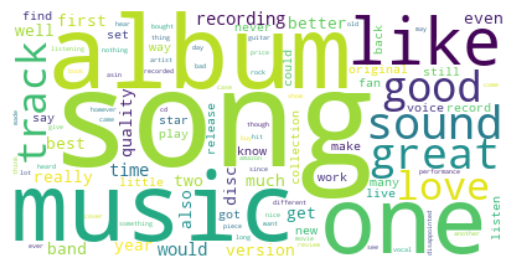

In [40]:
# creating wordcloud after text preprocessing
wcloud = WordCloud(max_words=100, background_color="white").generate_from_frequencies(freq_dist)

#plot the word cloud
plt.imshow(wcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

According to the above wordcloud, the top 100 most frequent words are meaningful words. This indicates that we can move on to feature extraction.

#### Which vectorization method to use?
To determine the most suitable vectorization method, we will test both TF-IDF and Word2Vec, as both are commonly used for text classification tasks. The model with the same algorithm will be applied with each vectorization method, and the model that performs better will dictate the choice of vectorization method.

##### Create word features using TF-IDF Feature

In [41]:
# build the dictionary
mydict = corpora.Dictionary(train_df['tokens_cleaned'])
vocab_len = len(mydict)

In [42]:
mydict = corpora.Dictionary(train_df['tokens_cleaned'])
vocab_len = len(mydict)
corpus = [mydict.doc2bow(line) for line in train_df['tokens_cleaned']]
tfidf_model = TfidfModel(corpus)

In [43]:
def get_tfidf_features_sparse(train_df, tokens_cleaned, mydict, tfidf_model, vocab_len):
    tfidf_sparse_list = []

    for _, row in train_df.iterrows():
        doc = mydict.doc2bow(row[tokens_cleaned])
        tfidf_vector = gensim.matutils.corpus2csc([tfidf_model[doc]], num_terms=vocab_len).T
        tfidf_sparse_list.append(tfidf_vector)

    return vstack(tfidf_sparse_list)  # Stack sparse vectors to form a sparse matrix

# Generate TF-IDF sparse matrix
tfidf_sparse_matrix = get_tfidf_features_sparse(train_df, 'tokens_cleaned', mydict, tfidf_model, vocab_len)

# Convert to DataFrame
tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf_sparse_matrix, 
                                             columns=[str(mydict[ele]) for ele in range(vocab_len)], 
                                             index=train_df.index)

# Display a preview
print(tfidf_df.head())

   not_good    around   asgeir     avant       bad   barnett     brett  \
0       1.0         0        0         0         0         0         0   
1         0  0.068615  0.18484  0.148424  0.059512  0.164281  0.145926   
2         0         0        0         0         0         0         0   
3         0         0        0         0         0         0         0   
4         0         0        0         0         0         0         0   

       cash      chet     chief  ...  innovate  jayhawkers  kije  \
0         0         0         0  ...         0           0     0   
1  0.108853  0.135453  0.132954  ...         0           0     0   
2         0         0         0  ...         0           0     0   
3         0         0         0  ...         0           0     0   
4         0         0         0  ...         0           0     0   

   psychologically  traumatized  wyler  24-page  88-track  full-color  \
0                0            0      0        0         0           0   


##### Creating a Training and validation dataset (TF-IDF)

In [44]:
X = tfidf_df.sparse.to_dense()
y = train_df[train_df.columns[:1]]

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(y_train_tfidf.sentiment.value_counts(normalize=True))

sentiment
Positive    0.378489
Negative    0.366425
Neutral     0.255086
Name: proportion, dtype: float64


##### Create word features using Word2vec

In [45]:
# Train Word2Vec model
model = Word2Vec(train_df["tokens_cleaned"], vector_size=100, window=5, min_count=1, sg=1)

In [46]:
def get_document_vector(tokens, model, vector_size=100):
    # Initialize an empty vector
    vector = np.zeros(vector_size)
    count = 0

    # Sum up the word vectors
    for word in tokens:
        if word in model.wv:
            vector += model.wv[word]
            count += 1

    # Avoid division by zero
    if count > 0:
        vector /= count

    return vector

# Create document embeddings
X_word2vec = [get_document_vector(tokens, model) for tokens in train_df['tokens_cleaned']]

##### Creating a Training and validation dataset (Word2vec)

In [47]:
# splitting 
X = X_word2vec
y = train_df[train_df.columns[:1]]

X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(y_train_word2vec.sentiment.value_counts(normalize=True))

sentiment
Positive    0.378489
Negative    0.366425
Neutral     0.255086
Name: proportion, dtype: float64


## Modelling
Perform the necessary steps and explain the rationale taken here.

To determine the best vectorization method, I used the Random Forest algorithm for the model. Random Forest is well-suited for this task as it naturally handles multi-class classification and reduces the risk of overfitting by averaging multiple decision trees.


##### Training Random Forest using TF-IDF

In [48]:
# Train Random Forest on TF-IDF features
rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_tfidf.fit(X_train_tfidf, y_train_tfidf)

C:\Users\admin\anaconda3\envs\jupyterenv\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [49]:
# classification report on the validation dataset
print(classification_report(y_test_tfidf, rf_tfidf.predict(X_test_tfidf)))

              precision    recall  f1-score   support

    Negative       0.66      0.79      0.72      1427
     Neutral       0.51      0.24      0.33       994
    Positive       0.69      0.82      0.75      1475

    accuracy                           0.66      3896
   macro avg       0.62      0.61      0.60      3896
weighted avg       0.64      0.66      0.63      3896



In [50]:
# calculate the accuracy score for validation dataset
y_pred_tfidf = rf_tfidf.predict(X_test_tfidf)
print("Accuracy Score: " + str(accuracy_score(y_test_tfidf, y_pred_tfidf)))

Accuracy Score: 0.6588809034907598


In [54]:
# find out the order of sentiments for the confusion matrix
print(train_df[train_df.columns[0]].unique())

['Negative' 'Neutral' 'Positive']


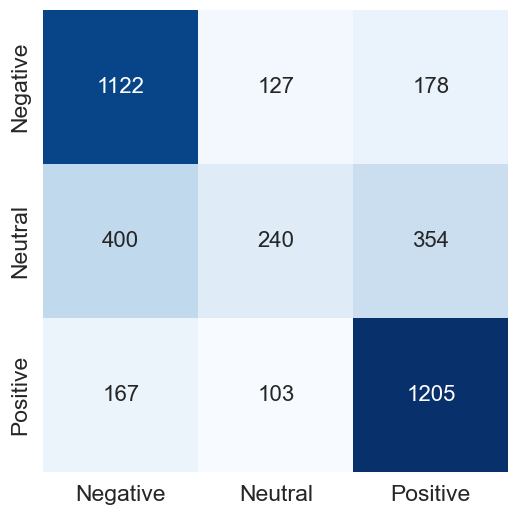

In [55]:
# creating the confusion matrix
def conf_matrix(y_test, pred_test):
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, index=["Negative", "Neutral", "Positive"], columns=["Negative", "Neutral", "Positive"])
   
    #Ploting the confusion matrix
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False) 

# Generating confusion matrix
conf_matrix(y_test_tfidf, y_pred_tfidf)

##### Training Random Forest with Word2vec

In [56]:
# Train Random Forest on TF-IDF features
rf_word2vec = RandomForestClassifier(n_estimators=100, random_state=42)
rf_word2vec.fit(X_train_word2vec, y_train_word2vec)

C:\Users\admin\anaconda3\envs\jupyterenv\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [57]:
# classification report on the validation dataset
print(classification_report(y_test_word2vec, rf_word2vec.predict(X_test_word2vec)))

              precision    recall  f1-score   support

    Negative       0.62      0.73      0.67      1427
     Neutral       0.43      0.23      0.30       994
    Positive       0.65      0.74      0.69      1475

    accuracy                           0.61      3896
   macro avg       0.57      0.57      0.55      3896
weighted avg       0.58      0.61      0.58      3896



In [58]:
# calculate the accuracy score for the validation dataset
y_pred_word2vec = rf_word2vec.predict(X_test_word2vec)
print("Accuracy Score: " + str(accuracy_score(y_test_word2vec, y_pred_word2vec)))

Accuracy Score: 0.6057494866529775


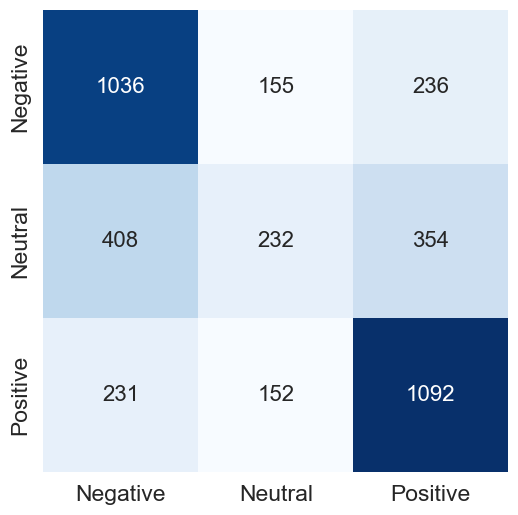

In [59]:
# consufion matrix on the validation data
conf_matrix(y_test_word2vec, y_pred_word2vec)

##### TF-IDF is better than Word2vec
The TF-IDF model (model with TF-IDF features) outperforms the Word2Vec model (model with word2vec features), achieving an accuracy of 65.89% compared to 60.57% for Word2Vec. In addition to the higher accuracy, the TF-IDF model shows stronger overall performance across sentiment categories, particularly for the Negative and Positive classes, with F1-scores of 0.72 and 0.75, respectively. These higher F1-scores reflect the model's ability to effectively classify these more distinct sentiment categories. However, the TF-IDF model struggles significantly with the Neutral class, where the recall drops to 0.24, meaning the model frequently misclassifies Neutral sentiments as either Negative or Positive. This suggests that the TF-IDF model is better at distinguishing extreme sentiment categories (Negative and Positive), but has difficulty capturing the nuances of Neutral sentiment, which may not be represented as clearly in the term frequencies.

On the other hand, the Word2Vec model, which relies on word embeddings that capture the semantic relationships between words, performs worse overall. Its lower accuracy of 60.96% and generally weaker performance across all sentiment categories indicate that the embeddings may not be well-suited for this specific sentiment classification task. Notably, the Neutral class proves to be a major challenge for Word2Vec as well, with a recall of just 0.23, indicating that the model often confuses Neutral sentiment with other categories. This performance could stem from difficulties in training word embeddings on a relatively smaller dataset, which may not allow the model to capture sufficient context for accurate sentiment classification. Additionally, Word2Vec does not explicitly prioritize the importance of individual words, unlike TF-IDF, which gives higher weight to more informative words based on their term frequency. As a result, Word2Vec may fail to differentiate between key terms that are crucial for distinguishing sentiment categories.

The lower performance of Word2Vec in this case highlights the importance of the training data and the specific nature of the features used. TF-IDF, which directly emphasizes word importance based on frequency, tends to work better in cases where sentiment differences are more explicit. Hence, the TF-IDF model (model with TF-IDF features) has performed better and the TF-IDF vectorization method will be used for the model.

#### Second model
##### Why use Naive Bayes as the second model's algorithm?
The Naive Bayes is well known to work well with high dimensional text data (Data with many text features).

In [60]:
# creating the model
nb_model = MultinomialNB()

In [61]:
# Training the model with training data
nb_model.fit(X_train_tfidf, y_train_tfidf)

C:\Users\admin\anaconda3\envs\jupyterenv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()

In [62]:
# classification report on the validation dataset
print(classification_report(y_test_tfidf, nb_model.predict(X_test_tfidf)))

              precision    recall  f1-score   support

    Negative       0.65      0.82      0.73      1427
     Neutral       0.56      0.04      0.07       994
    Positive       0.65      0.89      0.75      1475

    accuracy                           0.65      3896
   macro avg       0.62      0.58      0.51      3896
weighted avg       0.63      0.65      0.57      3896



In [63]:
# calculate the accuracy score for the validation dataset
y_pred_tfidf = nb_model.predict(X_test_tfidf)
print("Accuracy Score: " + str(accuracy_score(y_test_tfidf, y_pred_tfidf)))

Accuracy Score: 0.6475872689938398


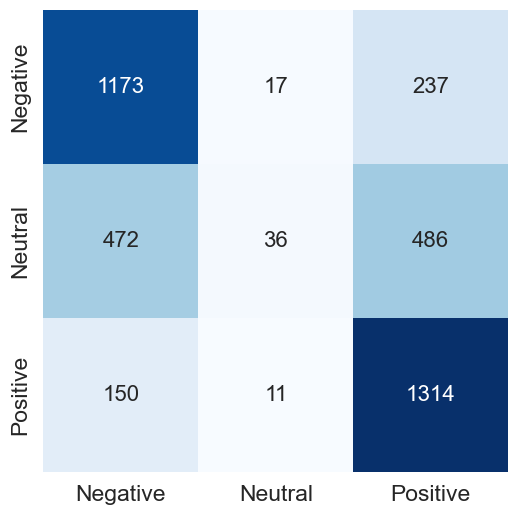

In [64]:
# consufion matrix on the validation data
conf_matrix(y_test_tfidf, y_pred_tfidf)

##### Whcih model has performed better
The Random Forest model outperforms the Naive Bayes model in both accuracy and overall performance. The Random Forest model achieves an accuracy of 65.89%, compared to 64.76% for Naive Bayes. It also performs better in terms of precision and recall for the Negative and Positive categories, with precision scores of 0.66 and 0.69, and recall scores of 0.79 and 0.82, respectively. These values indicate that Random Forest is more effective at correctly identifying Negative and Positive sentiments while minimizing misclassifications. However, the Random Forest model struggles with the Neutral class, where recall drops to 0.24, meaning it frequently misclassifies Neutral sentiments as either Negative or Positive. This highlights the model's difficulty in capturing the subtleties of Neutral sentiment, which might not be as distinctly represented by the term frequencies.

In contrast, the Naive Bayes model, with an accuracy of 64.76%, demonstrates a similar precision for Negative and Positive categories at 0.65 each. However, its recall for these categories is lower than that of Random Forest, with recall values of 0.82 for Negative and 0.89 for Positive. The Naive Bayes model faces a significant challenge with the Neutral class, where recall drops to 0.04, meaning it often misidentifies Neutral sentiments as either Negative or Positive. The precision for Neutral is 0.56, but the low recall indicates that the model struggles to accurately capture Neutral sentiments. This could be due to Naive Bayes' reliance on the assumption of feature independence, which may not be suitable for capturing the more nuanced patterns required for Neutral sentiment classification.

Overall, while both models perform similarly for Negative and Positive sentiments, the Random Forest model outperforms Naive Bayes in terms of precision and recall for these categories. However, both models struggle with the Neutral class, with Naive Bayes performing particularly poorly in terms of recall. The Random Forest model, leveraging TF-IDF features, provides better balance and more accurate performance across sentiment categories, making it the preferred choice for this sentiment classification task.

## Evaluation
Perform the necessary steps and explain the rationale taken here.

Since the Random Forst model was chosen as the best model, it is being testing using the testing data from the test_df which is not balanced

##### Testing the Random forest model using the testing data (test_df)

In [65]:
# creating matrix for the testing data
tfidf_test_sparse_matrix = get_tfidf_features_sparse(test_df, 'tokens_cleaned', mydict, tfidf_model, vocab_len)

In [66]:
# creating a df from the sparse matrix of testing data
tfidf_test_df = pd.DataFrame.sparse.from_spmatrix(tfidf_test_sparse_matrix, 
                                                  columns=[str(mydict[ele]) for ele in range(vocab_len)], 
                                                  index=test_df.index)

In [67]:
X_test_final_vect = tfidf_test_df

In [68]:
# testing the model with the testing data
y_test_final_pred = rf_tfidf.predict(X_test_final_vect)
y_test_actual = test_df['sentiment']

In [69]:
# # classification report on the testing dataset
print(classification_report(y_test_actual, y_test_final_pred))

              precision    recall  f1-score   support

    Negative       0.34      0.76      0.47      1784
     Neutral       0.16      0.27      0.20      1242
    Positive       0.96      0.82      0.89     20793

    accuracy                           0.79     23819
   macro avg       0.49      0.62      0.52     23819
weighted avg       0.88      0.79      0.82     23819



In [70]:
# calculate the accuracy score for the testing dataset
print("Accuracy Score: " + str(accuracy_score(y_test_actual, y_test_final_pred)))

Accuracy Score: 0.7886141315756329


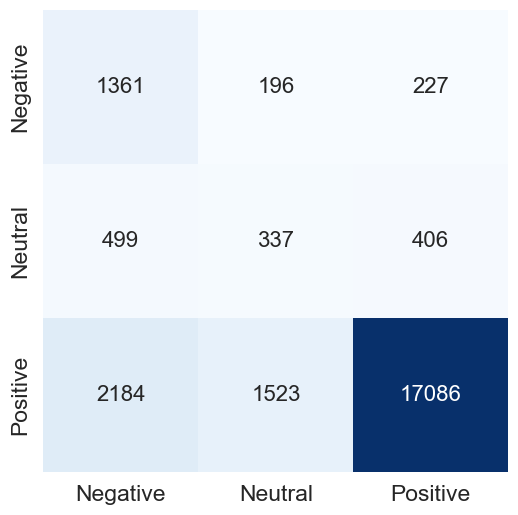

In [71]:
# consufion matrix on the testing data
conf_matrix(y_test_actual, y_test_final_pred)

##### How did the Random Forest model perform on unseen data (testing data)
On the training data, the Random Forest model achieved an accuracy of 65.89%, with strong performance for the Negative and Positive classes (F1-scores of 0.72 and 0.75, respectively), though it struggled with the Neutral class (F1-score of 0.33). On the other hand, when evaluated on the testing data, the model's accuracy increased significantly to 78.86%, suggesting that it generalizes well to unseen data. The testing data, however, is imbalanced, as the Positive class overwhelmingly dominates the dataset with a support of 20,793 instances, which likely skews the model's performance towards this class.

For the testing data, the model's precision for the Positive class is very high (0.96), indicating that it is very accurate when predicting Positive sentiment. However, it faces challenges with the Negative and Neutral classes. The recall for Negative sentiment is relatively high (0.76), but the recall for Neutral sentiment is significantly low (0.27).This shows the imbalance and difficulty in predicting less frequent classes. This is in contrast to the training data, where the model performed better overall, particularly in distinguishing Negative and Positive sentiments. The higher accuracy on the testing data could also be attributed to the model's strong ability to identify Positive sentiment, which is heavily represented in the data.

However, there is a potential risk of overfitting, as the model performs significantly better on the test data than on the training data. This could indicate that the model has learned the nuances of the test set too well, which might not be generalizable in different scenarios, particularly with more balanced data. Overfitting could also be implied by the difference between the recall for the Positive class (very high) and the much lower recall for the Neutral class, suggesting that the model is overly biased towards the more frequent sentiment.

In summary, the Random Forest model appears to perform well in generalizing to the test set, but the imbalanced nature of the testing data leads to a biased evaluation towards the Positive class. The model's ability to handle the Negative and Neutral classes still requires improvement, particularly in terms of recall and F1-score, which reflects its difficulty with less frequent classes. 

## Submission
Export your completed work as HTML. Select **File** > **Download as** > **HTML (.html)**.